# Title : Ventilator pressure prediction for estimating the airway pressure in the respiratory circuit during the breath

### What is a Ventilator?

A ventilator is a machine that helps people breathe (ventilate).These machines are often used in hospitals as life support for patients who have difficulty breathing or who have lost all ability to breathe on their own. Mechanical ventilation may be either invasive or noninvasive (e.g. using a tight-fitting external mask).Invasive modes require the insertion of internal tubes/devices through endotracheal intubation or tracheostomy.

### When Are Ventilators Used?

Many diseases and other factors can affect lung function and cause difficulty breathing to the point that a person may need a ventilator to stabilize their condition.

Examples include:-
- Respiratory infections like pneumonia, influenza (flu) and coronavirus (COVID-19)
- Lung diseases like asthma, COPD (chronic obstructive pulmonary disease), cystic fibrosis and lung cancer
- Acute respiratory distress syndrome (ARDS)
- Damage to the nerves and/or muscles involved in breathing (can be caused by upper spinal cord injuries, polio, amyotrophic lateral sclerosis, myasthenia gravis, etc.)
- Brain injury
- Stroke
- Drug overdose

Patients who can’t breathe on their own at all also use ventilators while undergoing treatment for the underlying condition(s) that caused respiratory failure or respiratory arrest. Long-term ventilator care may be needed if a patient cannot regain the ability to breathe independently.

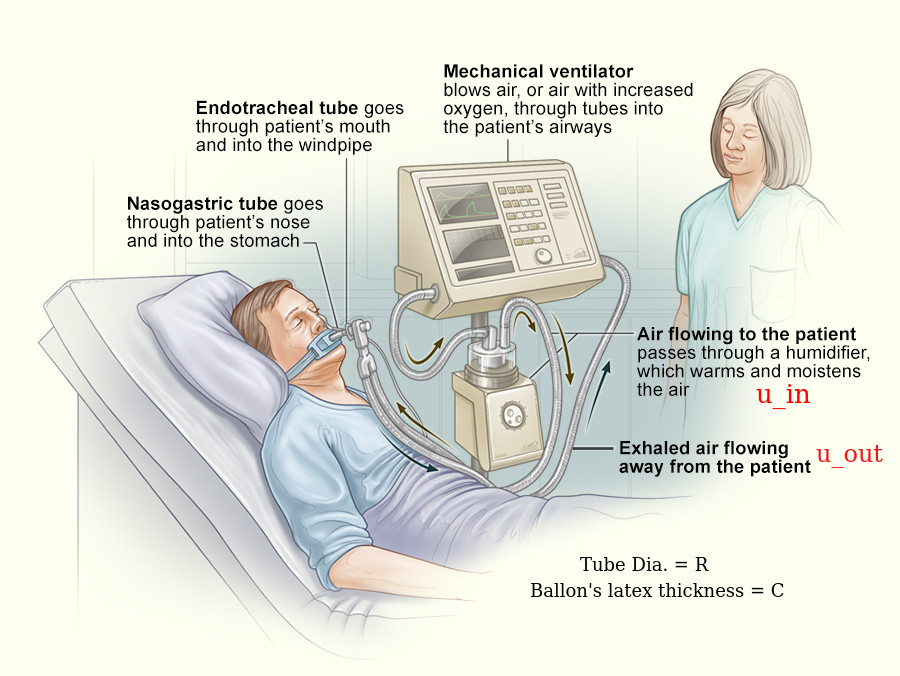

### How does a ventilator work?

A ventilator moves air into and out of the lungs (oxygen in and carbon dioxide out). It can be inserted through the mouth or nose, and down the trachea, or through a surgical opening, via tracheostomy. Depending on the patient’s medical condition, they may be able to use a respiratory mask in lieu of the breathing tubes. This is known as non-invasive mechanical ventilation.

The amount of oxygen the patient receives can be controlled through a monitor connected to the ventilator. If the patient’s condition is particularly delicate, the monitor will be set up to send an alarm to the caregiver indicating an increase in air pressure.

The machine works by bringing oxygen to the lungs and taking carbon dioxide out of the lungs. This allows a patient who has trouble breathing to receive the proper amount of oxygen. It also helps the patient’s body to heal, since it eliminates the extra energy of labored breathing.

p1.svg

# Imports

In [3]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 4.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 3.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 kB 2.7 MB/s eta 0:00:009.5 MB/s eta 0:00:01


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored
from IPython import display

import warnings

warnings.filterwarnings('ignore')

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Files

- train.csv - the training set
- test.csv - the test set

## Data Description
- id - globally-unique time step identifier across an entire file
- breath_id - globally-unique time step for breaths
- R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
- C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
- time_step - the actual time stamp.
- u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
- u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
- pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.(Target)

# Data Preprocessing

In [6]:
data = pd.read_csv('Data/train_folds_12.csv')
#test_data = pd.read_csv('/content/drive/MyDrive/MY_PROJECT/Data/test.csv')

In [7]:
data.drop('kfold', axis=1, inplace = True)

In [8]:
data.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [ ]:
data.info()

In [ ]:
print(f"Training Dataset Shape: {colored(data.shape, 'blue')}")


In [ ]:
data.memory_usage(deep=True)

In [9]:
data2 = data.copy()

In [10]:
# downcasting data to save memory

data2[["id","breath_id", "R","C", "u_out"]] = data2[["id","breath_id", "R","C", "u_out"]].apply(pd.to_numeric, downcast="unsigned")

data2[["time_step", "u_in", "pressure"]] = data2[["time_step", "u_in", "pressure"]].apply(pd.to_numeric, downcast="float")

data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         uint32 
 1   breath_id  uint32 
 2   R          uint8  
 3   C          uint8  
 4   time_step  float32
 5   u_in       float32
 6   u_out      uint8  
 7   pressure   float32
dtypes: float32(3), uint32(2), uint8(3)
memory usage: 132.4 MB


In [11]:

data2.memory_usage(deep=True)

Index             128
id           24144000
breath_id    24144000
R             6036000
C             6036000
time_step    24144000
u_in         24144000
u_out         6036000
pressure     24144000
dtype: int64

In [ ]:
# Columnwise Unique value

for col in data2.columns:
    print(col + ":" + colored(str(len(data2[col].unique())), 'blue'))


In [ ]:
data2.isnull().sum()

In [ ]:
# distribution plot

def plot_distribution(x, title):
    
    """
    Function to obtain the distribution plot of given data.
    
    params: x(string)     : Name of the Column for the Plot.
            title(string) : Title of the Plot
    """
    sns.displot(data2, x = x, kind="kde", bw_adjust=2)
    
    plt.title(title, fontsize = 12)
    plt.show()

In [ ]:
plot_list = [("R", "Lung Airway Restricted"),
             ("C", "Lung Compliance"),
             ("u_in", "Control input for the inspiratory solenoid"),
             ("u_out", "Control input for the exploratory solenoid valve"),
             ("pressure", "Airway pressure")
            ]

In [ ]:
for column, title in plot_list:
    plot_distribution(x = column, title = title)

In [ ]:
# count of R and C in data.

fig, ax = plt.subplots(figsize = (14, 8))
plt.subplot(2, 2, 1)
sns.countplot(x='R', data=data2)
plt.title('Counts of R ');
plt.subplot(2, 2, 2)
sns.countplot(x='C', data=data2)
plt.title('Counts of C ');


In [ ]:
data2['R'].value_counts()

In [ ]:
#for train set
pair_rc = data2.groupby(["R", "C"]).size().reset_index(name="Counts")
pair_rc["R"] = pair_rc[["R","C"]].apply(lambda cols: (cols[0],cols[1]),axis=1)
pair_rc.drop("C",axis=1,inplace=True)
pair_rc.rename(columns={'R':'R-C pair'},inplace=True)
plt.figure(figsize=(15,10))
sns.barplot(x="R-C pair",y="Counts",data=pair_rc);
plt.title("Counts of R-C pairs ");

In [ ]:
def show_correlogram(df):
    plt.figure(figsize=(20,10), dpi= 80)
    sns.heatmap(
        df.corr(), xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='coolwarm', center=0, annot=True, cbar=False
    )
    plt.title('Correlogram between features', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [ ]:
show_correlogram(data2)

In [ ]:
for i in range(1,6,1):
    one_breath = data2[data2["breath_id"]==i]

    plt.figure(figsize=(8,6));
    sns.lineplot(x = 'id',y='pressure',data=one_breath[one_breath['u_out']==0],color='green',label='pressure inhale');
    sns.lineplot(x = 'id',y='pressure',data=one_breath[one_breath['u_out']==1],color='orange',label='pressure exhale');
    sns.lineplot(x = 'id',y='u_in',data=one_breath,color='blue',label='valve position')
    plt.title(f"Variation of Pressure and Input valve position during breath {i}");
    plt.legend();

In [ ]:
# Plot of 10 breath_id
ten_breath = data2[:800]

plt.figure(figsize=(20,6));
sns.lineplot(x = 'id',y='pressure',data=ten_breath[ten_breath['u_out']==0],color='green',label='pressure inhale- pressure till u_out =0');
sns.lineplot(x = 'id',y='pressure',data=ten_breath[ten_breath['u_out']==1],color='orange',label='pressure exhale-  pressure till u_out =1');
sns.lineplot(x = 'id',y='u_in',data=ten_breath,color='blue',label='valve position- u_in')
plt.title("Variation of Pressure and Input valve position during breath");
plt.legend();

In [ ]:
# Plot of 10 breath_id 
ten_breath = data2[:800]

plt.figure(figsize=(20,6));
sns.lineplot(x = 'id',y='pressure',data=ten_breath,color='green',label='pressure');
sns.lineplot(x = 'id',y='u_in',data=ten_breath,color='blue',label='valve position- u_in')
plt.title("Variation of Pressure and Input valve position during breath");
plt.legend();

In [12]:
# 25% data 
x= int(len(data2)/4)
x

1509000

In [47]:
df = data2[:x]

## Adding some features

In [48]:
df['area'] = df.u_in *df.u_out
df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()

In [49]:
df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
df = df.fillna(0)

In [50]:
df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']

In [51]:
# show_correlogram(df)

In [52]:
df['R_'] = df['R'].astype(str)
df['C_'] = df['C'].astype(str)
df['R__C'] = df["R_"].astype(str) + '__' + df["C_"].astype(str)

In [53]:
df.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'area', 'time_step_cumsum', 'u_in_cumsum', 'u_in_lag1', 'u_out_lag1',
       'u_in_lag_back1', 'u_out_lag_back1', 'u_in_lag2', 'u_out_lag2',
       'u_in_lag_back2', 'u_out_lag_back2', 'u_in_lag3', 'u_out_lag3',
       'u_in_lag_back3', 'u_out_lag_back3', 'u_in_lag4', 'u_out_lag4',
       'u_in_lag_back4', 'u_out_lag_back4', 'breath_id__u_in__max',
       'breath_id__u_in__mean', 'breath_id__u_in__diffmax',
       'breath_id__u_in__diffmean', 'R_', 'C_', 'R__C'],
      dtype='object')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509000 entries, 0 to 1508999
Data columns (total 34 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id                         1509000 non-null  uint32 
 1   breath_id                  1509000 non-null  uint32 
 2   R                          1509000 non-null  uint8  
 3   C                          1509000 non-null  uint8  
 4   time_step                  1509000 non-null  float32
 5   u_in                       1509000 non-null  float32
 6   u_out                      1509000 non-null  uint8  
 7   pressure                   1509000 non-null  float32
 8   area                       1509000 non-null  float32
 9   time_step_cumsum           1509000 non-null  float32
 10  u_in_cumsum                1509000 non-null  float32
 11  u_in_lag1                  1509000 non-null  float32
 12  u_out_lag1                 1509000 non-null  float64
 13  u_in_lag_bac

In [55]:
df1 = df[:80]

In [56]:
df1.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,area,time_step_cumsum,...,u_out_lag4,u_in_lag_back4,u_out_lag_back4,breath_id__u_in__max,breath_id__u_in__mean,breath_id__u_in__diffmax,breath_id__u_in__diffmean,R_,C_,R__C
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.0,0.000000,...,0.0,25.355850,0.0,28.313036,10.146007,28.229702,10.062673,20,50,20__50
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.0,0.033652,...,0.0,27.259867,0.0,28.313036,10.146007,9.929995,-8.237035,20,50,20__50
2,3,1,20,50,0.067514,22.509277,0,7.876254,0.0,0.101167,...,0.0,27.127485,0.0,28.313036,10.146007,5.803759,-12.363271,20,50,20__50
3,4,1,20,50,0.101542,22.808823,0,11.742872,0.0,0.202709,...,0.0,26.807732,0.0,28.313036,10.146007,5.504213,-12.662816,20,50,20__50
4,5,1,20,50,0.135756,25.355850,0,12.234987,0.0,0.338464,...,0.0,27.864716,0.0,28.313036,10.146007,2.957186,-15.209844,20,50,20__50


In [57]:
df1.shape

(80, 34)

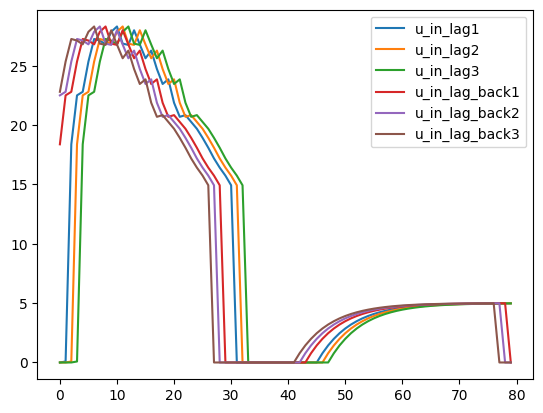

In [58]:
df1['u_in_lag1'].plot()
df1['u_in_lag2'].plot()
df1['u_in_lag3'].plot()
df1['u_in_lag_back1'].plot()
df1['u_in_lag_back2'].plot()
df1['u_in_lag_back3'].plot()
plt.legend()

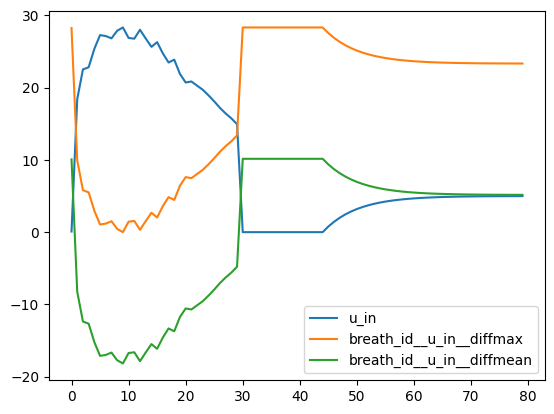

In [59]:
df1['u_in'].plot()
df1['breath_id__u_in__diffmax'].plot()
df1['breath_id__u_in__diffmean'].plot()
plt.legend()

In [60]:
from sklearn.preprocessing import OneHotEncoder

In [61]:
df_categorical = df.select_dtypes(include=[np.object])

In [62]:
df_categorical.head()

,R_,C_,R__C
0,20,50,20__50
1,20,50,20__50
2,20,50,20__50
3,20,50,20__50
4,20,50,20__50


In [63]:
ohe = OneHotEncoder() 
ohe.fit(df_categorical) 
df_ohe = ohe.transform(df_categorical).toarray() # Perform one-hot encoding
df_ohe = pd.DataFrame(df_ohe)

In [64]:
final_df = df.join(df_ohe)

In [65]:
final_df.shape

(1509000, 49)

In [66]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509000 entries, 0 to 1508999
Data columns (total 49 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id                         1509000 non-null  uint32 
 1   breath_id                  1509000 non-null  uint32 
 2   R                          1509000 non-null  uint8  
 3   C                          1509000 non-null  uint8  
 4   time_step                  1509000 non-null  float32
 5   u_in                       1509000 non-null  float32
 6   u_out                      1509000 non-null  uint8  
 7   pressure                   1509000 non-null  float32
 8   area                       1509000 non-null  float32
 9   time_step_cumsum           1509000 non-null  float32
 10  u_in_cumsum                1509000 non-null  float32
 11  u_in_lag1                  1509000 non-null  float32
 12  u_out_lag1                 1509000 non-null  float64
 13  u_in_lag_bac

# Train Test Split

In [67]:
# X = df.drop(['pressure'], axis=1)
# y = df.pressure

In [68]:
X = final_df.drop(['pressure',"R_",'C_','R__C'], axis=1)
y = final_df.pressure

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509000 entries, 0 to 1508999
Data columns (total 45 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id                         1509000 non-null  uint32 
 1   breath_id                  1509000 non-null  uint32 
 2   R                          1509000 non-null  uint8  
 3   C                          1509000 non-null  uint8  
 4   time_step                  1509000 non-null  float32
 5   u_in                       1509000 non-null  float32
 6   u_out                      1509000 non-null  uint8  
 7   area                       1509000 non-null  float32
 8   time_step_cumsum           1509000 non-null  float32
 9   u_in_cumsum                1509000 non-null  float32
 10  u_in_lag1                  1509000 non-null  float32
 11  u_out_lag1                 1509000 non-null  float64
 12  u_in_lag_back1             1509000 non-null  float32
 13  u_out_lag_ba

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42 )

# Training Model

## Linear Regression

In [71]:
LR = LinearRegression()

In [72]:
LR.fit(X_train, y_train)

LinearRegression()

In [73]:
y_prediction =  LR.predict(X_test)

In [74]:
y_prediction[:80]

array([ 6.10617968,  7.31413768,  8.74369515,  8.66511921, 18.70445937,
       20.83965452,  8.00714893, 12.43438929, 10.45197498,  6.98814346,
       17.76877078,  3.5181835 , 16.16881855,  6.71133584,  7.21452641,
       21.14540207, 22.12317703,  5.02611541,  4.10370688,  4.15339168,
       20.52886442,  5.91877273,  9.93867575,  5.5236452 , 18.92013335,
        6.99872878,  4.45960495,  5.39594231,  7.98336076, 17.01023898,
       18.90076125,  4.6235163 , 10.74861171,  6.53918394,  5.85093129,
        8.80887316,  7.54723832, 25.52998716,  5.17834659,  5.09904918,
       13.97341337,  8.52892786, 32.99563314,  1.88875233,  5.95496149,
        6.37748978, 20.93052392, 28.64766792,  8.44021779,  9.4849266 ,
        5.37860931,  5.12350202, 19.22267098,  6.72569032, 30.2621465 ,
        7.40480292,  7.73991908, 17.3924495 ,  9.48718747,  3.83370934,
       20.0467393 , 20.36405797, 14.26646253, 19.86395098,  7.65097398,
        6.05516744, 10.12407683, 10.83403156,  8.77790929,  8.21

In [75]:
y_test[:80]

498592      7.735650
525178      6.610816
218881      3.869032
93401      11.672570
50911      28.263876
             ...    
1381526     6.610816
1184932     7.805952
872901     32.200798
921117      6.892024
1444822    16.593719
Name: pressure, Length: 80, dtype: float32

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
print('Mean Squared Error :',mean_squared_error(y_test, y_prediction))
print('Mean Absolute Error :', mean_absolute_error(y_test, y_prediction))
print("Mean Absolute Percentage Error :", mean_absolute_percentage_error(y_test, y_prediction))


Mean Squared Error : 18.87701940215723
Mean Absolute Error : 3.0322248199656516
Mean Absolute Percentage Error : 0.3829147087157494


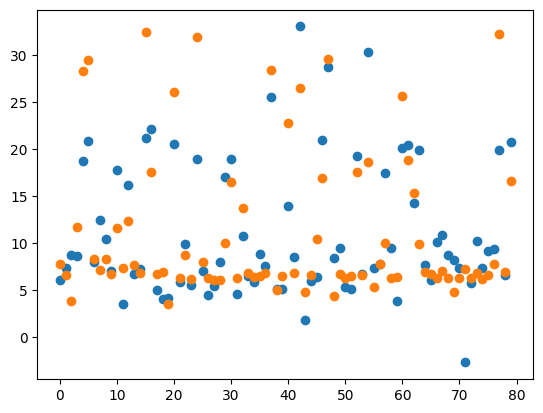

In [77]:
plt.scatter(x = [range(0,80)], y = y_prediction[:80], cmap = 'RdPu')
plt.scatter(x = [range(0,80)], y = y_test[:80])
plt.show()

## Random Forest Regressor

In [78]:
from sklearn.ensemble import RandomForestRegressor

In [79]:
RFR = RandomForestRegressor(n_estimators=100, random_state =42 )

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
RFR.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [82]:
y_predicted_rfr = RFR.predict(X_test)

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
print('Mean Squared Error :',mean_squared_error(y_test, y_predicted_rfr))
print('Mean Absolute Error :', mean_absolute_error(y_test, y_predicted_rfr))
print("Mean Absolute Percentage Error :", mean_absolute_percentage_error(y_test, y_predicted_rfr))

Mean Squared Error : 0.47769708536851435
Mean Absolute Error : 0.3606539083388736
Mean Absolute Percentage Error : 0.033306206995953866


In [ ]:
# RFR result before adding R__C feature

# Mean Squared Error : 1.1901127829197762
# Mean Absolute Error : 0.533769046207269
# Mean Absolute Percentage Error : 0.04912072955358952

In [ ]:
# After parameter tuning using gridsearchcv
#     n_estimator = 300
#     max_depth = 4

In [42]:
RFR300 = RandomForestRegressor(n_estimators=300,  random_state =42 )

In [43]:
RFR300.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [44]:
y_predicted_300 = RFR300.predict(X_test)

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
print('Mean Squared Error :',mean_squared_error(y_test, y_predicted_300))
print('Mean Absolute Error :', mean_absolute_error(y_test, y_predicted_300))
print("Mean Absolute Percentage Error :", mean_absolute_percentage_error(y_test, y_predicted_300))

Mean Squared Error : 1.0247586332940326
Mean Absolute Error : 0.5336203667866687
Mean Absolute Percentage Error : 0.04884252138123074


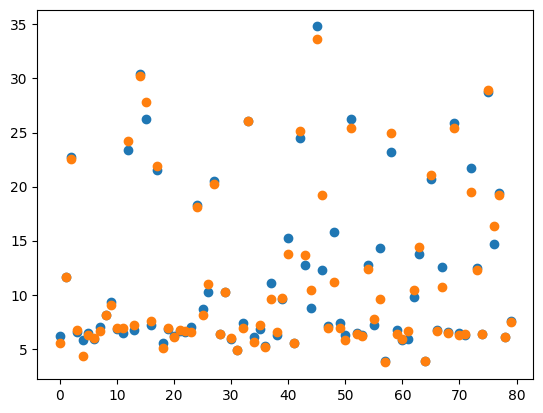

In [46]:
plt.scatter(x = [range(0,80)], y = y_predicted_300[:80], cmap = 'RdPu')
plt.scatter(x = [range(0,80)], y = y_test[:80])
plt.show()

In [ ]:
# As Data Contains 6036000 rows and there are 80 rows for a breath so, 6036000/80 = 75450 breath data.


#we are taking 600 breath data i.e 48000 rows..
# Results of from RFR_300 model is as below :

      # Mean Squared Error : 0.8738172240129713
      # Mean Absolute Error : 0.49386244145091807
      # Mean Absolute Percentage Error : 0.04466684779598285


# we are taking 1000 breath data i.e 80000 rows..
# Results of from RFR_300 model is as below :

      # Mean Squared Error : 0.8053762916982942
      # Mean Absolute Error : 0.4728391218840095
      # Mean Absolute Percentage Error : 0.04212987088280841

# we are taking 2000 breath data i.e 160000 rows.. 
#   Results from RFR  model
#     Mean Squared Error : 0.7055180968594689
#     Mean Absolute Error : 0.44608249148228424
#     Mean Absolute Percentage Error : 0.04033956583589433

# Results of from RFR_300 model : Colab crashed



# Now After downcast the data types used 1/4 th data to train RFR

# Mean Squared Error : 0.47769708536851435
# Mean Absolute Error : 0.3606539083388736
# Mean Absolute Percentage Error : 0.033306206995953866




In [ ]:
   
def process_visualisation(df, breath_id):
    plt.figure(figsize=(14, 6))
    plt.title('Breath Id - {}'.format(breath_id))
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['pressure'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['u_in'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['u_out'])
    plt.grid()
    plt.legend()
    plt.ylabel('Value')
    plt.show()

In [ ]:
def process_visualisation_with_preds(df, df_preds, breath_id):
    plt.figure(figsize=(14, 6))
    plt.title('Breath Id - {}'.format(breath_id))
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['pressure'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['u_in'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['u_out'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df_preds)
    plt.grid()
    plt.legend()
    plt.ylabel('Value')
    plt.show()

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/MY_PROJECT/Data/test.csv')

In [ ]:
test_data.head()